# Demonstration book of WaveGlow

This demonstration book will:
    
1. Define components in the model
2. Load pre-trained model and generate waveform samples


A few notes:
* Official implementation is in https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2/waveglow
* Model here is re-implemented for tutorial purpose
* It is NOT intended to surpass the official implementation
* Post-processing such as de-noising is not include in this notebook
* Your contribution is welcome to improve it

Modules for WaveGlow are defined in `../sandbox/block_waveglow.py`. For convenience, I copy those modules to this notebook and demonstrate the usage.

The project to train and run a WaveGlow on CMU arctic database is available in `../project/05-nn-vocoder/waveglow`.


## 1. Define a WaveGlow

WaveGlow in the paper has a fixed model structure

* **Condition module**: process and up-sample input conditional features
* **Squeeze module**: squeeze the length of target waveform and input conditional features
* WaveGlow core: **3 WaveGlow blocks**, each block contains **4 flow steps**, and each flow steps contains **8 dilated conv layers**.

WaveGlow paper simply says **12 coupling layers and 12 invertible 1x1 convolutions**, **output 2 of the channels after every 4 coupling layers**.  

But it is more convienient to define the casacade of one coulpling layer and one 1x1 conv layer as one **flow step**; then **4 flow steps** makes one WaveGlow block. The early outputs will be extracted from the output of the 1st and 2nd WaveGlow blocks.

('Flow step' may not be the best name here. I will use it here)

**During training**

* input feature is in shape (B, N, D), i.e., (Batch, Num_of_frame, Dimension)
* target waveorm is in shape (B, T, 1), i.e., (Batch, Time length, 1)
* maximize the likelihood $\sum_{b=1}^{3} \log \mathcal{N}(\boldsymbol{z}_{b}; \boldsymbol{0}, \boldsymbol{I}) + \log(\det|Jac|_b)$

$z_1, z_2$ are referred to as 'early output' -- latent z extracted from the 1st and 2nd WaveGlow block. This is also called multi-scale in Glow (Kingma, D. P. & Dhariwal, P. Glow: Generative Flow with Invertible 1x1 Convolutions. arXiv Prepr. arXiv1807.03039 (2018)).

```sh
.
                                 ===============================================  
                                 | WaveGlow Core                               |  
                                 |       |---------------------------------------> log_detJac1
                                 |       |---------------------------------------> z1 -> N(0, I)  (B, T/8, 2)
                                 |       |                                     |   
                                 |       |              |------------------------> log_detJac2
                                 |       |              |------------------------> z2 -> N(0, I)  (B, T/8, 2)
                                 |       |              |                      |
            --------- (B, T/8, 8)|  -----------    -----------    ----------- ---> log_detJac3 
Waveform -->|squeeze| ------------> |WGBlock 1| -> |WGBlock 2| -> |WGBlock 3| ---> z3 -> N(0, I)  (B, T/8, 4)
(B, T, 1)   ---------            |  -----------    -----------    -----------  |
                                 |       ^              ^              ^       |
                                 ========|==============|==============|========
            ---------                    ---------------|---------------   
            |squeeze| -----------------------------------
            ---------                              (B, T/8, 8D)
                ^      
                | up-sampled features (B, T, D)
            -----------
input_feat->|condition|
(B, N, D)   -----------
```     

**During generation**

* input feature is in shape (Batch, Num_of_frame, Dimension)
* target waveorm is in shape (Batch, Time length, 1)
* Draw random noise $\{\boldsymbol{z}_1, \boldsymbol{z}_2, \boldsymbol{z}_3\}$ and do reverse transformation 

```sh
.
                                 ===============================================  
                                 | WaveGlow Core                               |  
                                 |                                             |
                                 |       |--------------------------------------- z1 <- N(0, I)  (B, T/8, 2)
                                 |       |                                     |   
                                 |       |                                     |
                                 |       |              |------------------------ z2 <- N(0, I)  (B, T/8, 2)
                                 |       v              v                      |
            --------- (B, T/8, 8)|  -----------    -----------    -----------  |
Waveform <--|de-sque| <-----------  |WGBlock 1| <- |WGBlock 2| <- |WGBlock 3| <-- z3 <- N(0, I)  (B, T/8, 4)
(B, T, 1)   ---------            |  -----------    -----------    -----------  |
                                 |       ^              ^              ^       |
                                 ========|==============|==============|========
            ---------                    ---------------|---------------   
            |squeeze| -----------------------------------
            ---------                              (B, T/8, 8D)
                ^      
                | up-sampled features (B, T, D)
            -----------
input_feat->|condition|
(B, N, D)   -----------

```

Details of each module or block are illustrated in the following sections

### 1.1 Preparation

In [1]:
# load packages 
from __future__ import absolute_import
from __future__ import print_function
import os
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# basic nn blocks
import sandbox.block_nn as nii_nn
import sandbox.util_dsp as nii_dsp
import sandbox.block_glow as nii_glow
import core_scripts.data_io.conf as nii_io_conf

# misc functions for this demonstration book

from plot_tools import plot_API
from plot_tools import plot_lib
import tool_lib
import plot_lib as plot_lib_legacy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

### 1.1 Condition module

It transforms and up-samples the input acoustic features (e.g., Mel-spec)
```sh
.
                                  ===================================
                                  | condition module                |
          input_feat              |  ----------------------------   |         up-sampled features 
(Batch, frame_num, dimension)  -> |  | transposed convolution 1d|   |  -> (Batch, waveform_length, dimension)
                                  |  ----------------------------   |
                                  ===================================
```


Similar to the condition modules in WaveNet and many other vocoders, the waveform length = frame_num * up-samplg rate.  The up-sampling rate is decided by the waveform sampling rate and the frame-shift when extracting the input features. For example, 5ms frame-shift on 16kHz waveform -> 16 * 5 = 80. Each frame must be up-sampled to a factor of 80.

A condition module can be in numerous ways. Here we try transposed convolution (https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose1d.html)

In [2]:
class upsampleByTransConv(torch_nn.Module):
    """upsampleByTransConv
    Upsampling layer using transposed convolution
    """
    def __init__(self, feat_dim, upsample_rate, window_ratio=5):
        """upsampleByTransConv(feat_dim, upsample_rate, window_ratio=5)
        
        Args
        ----
          feat_dim: int, input feature should be (batch, length, feat_dim)
          upsample_rate, int, output feature will be 
                (batch, length*upsample_rate, feat_dim)
          window_ratio: int, default 5, window length of transconv will be 
                upsample_rate * window_ratio
        """
        super(upsampleByTransConv, self).__init__()
        window_l = upsample_rate * window_ratio
        self.m_layer = torch_nn.ConvTranspose1d(
            feat_dim, feat_dim, window_l, stride=upsample_rate)
        self.m_uprate = upsample_rate
        return
    
    def forward(self, x):
        """ y = upsampleByTransConv(x)
        
        input
        -----
          x: tensor, (batch, length, feat_dim)
          
        output
        ------
          y: tensor, (batch, length*upsample_rate, feat_dim)
        """
        l = x.shape[1] * self.m_uprate
        y = self.m_layer(x.permute(0, 2, 1))[:, :, 0:l]
        return y.permute(0, 2, 1).contiguous()

In [3]:
# Example

batch = 2
frame_num = 10
dimension = 5
upsample_rate = 80

m_cond = upsampleByTransConv(dimension, upsample_rate)

Input feature batch 2, frame 10, dim 5 
Output feature batch 2, frame 800, dim 5 


(<Figure size 720x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc379505a60>)

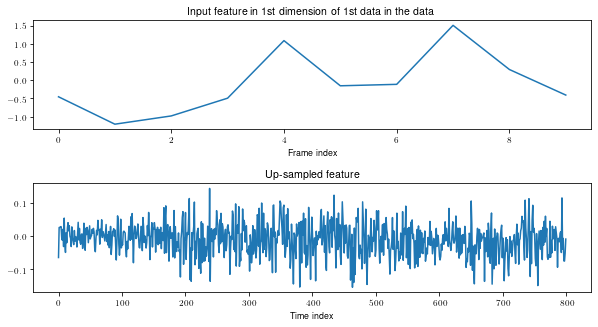

In [4]:
input_data = torch.randn([batch, frame_num, dimension])
with torch.no_grad():
    output_data = m_cond(input_data)
    

print("Input feature batch {:d}, frame {:d}, dim {:d} ".format(*input_data.shape))
print("Output feature batch {:d}, frame {:d}, dim {:d} ".format(*output_data.shape))

plot_API.plot_API([input_data[0, :, 0].numpy(), output_data[0, :, 0].numpy()], plot_lib.plot_signal, 'v',
                 {'sub': [{'title': "Input feature in 1st dimension of 1st data in the data", 'xlabel': 'Frame index'},
                          {'title': "Up-sampled feature", 'xlabel': "Time index"}],
                  'hspace': 0.5})

# The conv layer is randomly initialized, the up-sampled feature may be quite random.

### 1.2 Squeeze

Squeeze module changes the shape of the input feature.

Pay attention to the following points:
* How to align the elements in the last dimension when the last dimension is >1?
* Reverse operation should be implemented
* WaveGlow squeeze by a factor of 8

```sh
.
                      --------- 
         Waveform <-> |squeeze| <-> Squeezed waveform 
          (B, T, 1)   ---------       (B, T/8, 8)
          
                      --------- 
          Feature <-> |squeeze| <-> Squeezed Feature
          (B, T, D)   ---------       (B, T/8, 8D)
```

In [6]:
class SqueezeForWaveGlow(torch_nn.Module):
    """SqueezeForWaveGlow
    Squeeze layer for WaveGlow
    """
    def __init__(self, mode = 1, mode_1_para=8):
        """SqueezeForGlow(mode=1)
        Args
        ----
          mode: int, mode of this squeeze layer
          mode_1_para: int, factor of squeeze (default 8)
          
        mode == 1: original squeeze method by squeezing 8 points
        
        """
        super(SqueezeForWaveGlow, self).__init__()
        self.m_mode = mode
        self.m_mode_1_para = mode_1_para
        return
    
    def get_expected_squeeze_length(self, orig_length):
        # return expected length after squeezing
        if self.m_mode == 1:
            return orig_length//self.m_mode_1_para
    
    def get_squeeze_factor(self):
        # return the configuration for squeezing
        if self.m_mode == 1:
            return self.m_mode_1_para
    
    def forward(self, x):
        """SqueezeForWaveGlow(x)
        
        input
        -----
          x: tensor, (batch, length, feat_dim)
        
        output
        ------
          y: tensor, (batch, length // squeeze, feat_dim * squeeze)
        """
        if self.m_mode == 1:
            # squeeze, the 8 points should be the last dimension
            squeeze_len = x.shape[1] // self.m_mode_1_para
            # trim length first
            trim_len = squeeze_len * self.m_mode_1_para
            x_tmp = x[:, 0:trim_len, :]
            
            # (batch, time//squeeze_size, squeeze_size, dim)
            x_tmp = x_tmp.view(x_tmp.shape[0], squeeze_len, 
                               self.m_mode_1_para, -1)
            
            # (batch, time//squeeze_size, dim, squeeze_size)
            x_tmp = x_tmp.permute(0, 1, 3, 2).contiguous()
            
            # (batch, time//squeeze_size, dim * squeeze_size)
            return x_tmp.view(x_tmp.shape[0], squeeze_len, -1)
        else:
            print("SqueezeForWaveGlow not implemented")
        return x_squeezed

    def reverse(self, x_squeezed):
        if self.m_mode == 1:
            # (batch, time//squeeze_size, dim * squeeze_size)
            batch, squeeze_len, squeeze_dim = x_squeezed.shape
            
            # (batch, time//squeeze_size, dim, squeeze_size)
            x_tmp = x_squeezed.view(
                batch, squeeze_len, squeeze_dim // self.m_mode_1_para, 
                self.m_mode_1_para)
            
            # (batch, time//squeeze_size, squeeze_size, dim)
            x_tmp = x_tmp.permute(0, 1, 3, 2).contiguous()
            
            # (batch, time, dim)
            x = x_tmp.view(batch, squeeze_len * self.m_mode_1_para, -1)
        else:
            print("SqueezeForWaveGlow not implemented")
        return x

Let's use example to show it.

For explanation, we set the squeeze factor to 3.

In [7]:
m_squeeze = SqueezeForWaveGlow(mode_1_para=3)

(<Figure size 108x72 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7fc368731dc0>])

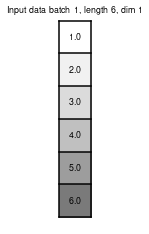

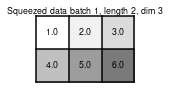

In [8]:
# First example
# last dimension size is 1, like waveform, (B, T, 1)

# create input (B=1, T=6, 1)
length = 6
input_data = torch.tensor([np.arange(length)+1]).T
input_data = input_data.unsqueeze(0)

# squeeze
with torch.no_grad():
    squeezed_data = m_squeeze(input_data)
    
plot_lib_legacy.plot_tensor(input_data, title="Input data batch {:d}, length {:d}, dim {:d} ".format(*input_data.shape), color_on_value=True)
plot_lib_legacy.plot_tensor(squeezed_data, title="Squeezed data batch {:d}, length {:d}, dim {:d} ".format(*squeezed_data.shape), color_on_value=True)

Note that, **the heigth of the matrix in the figure corresponds to the time axis**

(For a tensor of shape (B, T, D), the height of the matrix in the figure corresponds to length T, the width of the matrix in the figure corresponds to dimension D.)


(<Figure size 223.2x79.2 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fc3995aae50>])

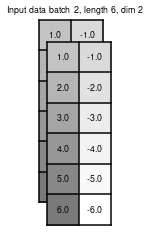

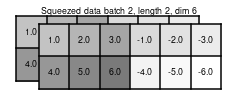

In [9]:
# Second example, 
# data has shape (B=2, T=6, 2)

# create a data of shape (batch=2, length=6, dimension=2)
length = 6
input_data = torch.tensor([np.arange(length)+1, np.arange(length)*-1-1]).T
input_data = torch.stack([input_data, input_data], dim=0)

# squeeze
with torch.no_grad():
    squeezed_data = m_squeeze(input_data)
    
plot_lib_legacy.plot_tensor(input_data, title="Input data batch {:d}, length {:d}, dim {:d} ".format(*input_data.shape), color_on_value=True)
plot_lib_legacy.plot_tensor(squeezed_data, title="Squeezed data batch {:d}, length {:d}, dim {:d} ".format(*squeezed_data.shape), color_on_value=True)

In the above example, the input data has shape (2, 6, 2). The squeezed data has shape (2, 2, 6)

input_data[0, 0:3, 0]=[1.0, 2.0, 3.0] and input_data[0, 0:3, 1] =[-1.0, -2.0, -3.0] are squeezed into squeezed_data[0, 0, 0:6]

In [10]:
print(input_data[0, 0:3, 0])
print(input_data[0, 0:3, 1])
print(squeezed_data[0, 0, 0:6])

tensor([1, 2, 3])
tensor([-1, -2, -3])
tensor([ 1,  2,  3, -1, -2, -3])


**How to align the elements in the last dimension when the last dimension is >1?**

As the example shows, elements adjacent in time are adjace in the squeezed tensor. Therefore, squeezed_data[0, 0, 0:6] is [1, 2, 3, -1, -2, -3], **NOT** [1, -1, 2, -2, 3, -3]

**Reverse (de-squeeze)**

It is straightforward to de-squeeze

(<Figure size 79.2x223.2 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fc3797ee880>])

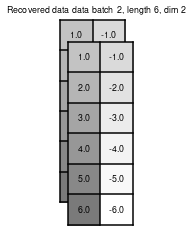

In [11]:
# de-squeeze
with torch.no_grad():
    de_squeezed_data = m_squeeze.reverse(squeezed_data)

plot_lib_legacy.plot_tensor(de_squeezed_data, title="Recovered data data batch {:d}, length {:d}, dim {:d} ".format(*de_squeezed_data.shape), color_on_value=True)

### 1.3 First glimpse on WaveGlow core part

The WaveGlow core module contains **3 WaveGlow blocks (WGBlocks)**, each WGBlock contains **4 WaveGlow flow steps**.

```sh
.          ===============================================  
           | WaveGlow Core                               |  
           |       |---------------------------------------> log_detJac1
           |       |---------------------------------------> z1 -> N(0, I)  (B, T/8, 2)
           |       |                                     |   
           |       |              |------------------------> log_detJac2
           |       |              |------------------------> z2 -> N(0, I)  (B, T/8, 2)
           |       |              | 3                     |
           |  ----------- 1  ----------- 4  ----------- ---> log_detJac3 
Squeezed ---> |WGBlock 1| -> |WGBlock 2| -> |WGBlock 3| ---> z3 -> N(0, I)  (B, T/8, 4)
  wave     |  -----------    -----------    -----------  |
(B, T/8, 8)|       ^              ^ 2            ^       |
           ========|==============|==============|========
                   ---------------|---------------   
                  up-sampled and squeezed feature
                             (B, T/8, 8D)
```

**WaveGlow block (WGBlock)**
```sh
.                                                               |-----------> log_detJac
                                                            3   |       |---> early output z   
                                                                |       |      (B, T/8, d)
           =====================================================|==========   
           | WaveGlow block                                     |       | |  
           |       -------------> + -----------> + ------------ +       | | 
           |       |              ^              ^              ^       | |  
           |       |              |              |              |       | |
           |  -----------    -----------    -----------    -----------  | | 4 
    1     --> |Flowstep1| -> |Flowstep2| -> |Flowstep3| -> |Flowstep4| ---|-> input to next block x
(B, T/8, P)|  -----------    -----------    -----------    -----------    |    (B, T/8, P-d)
           |       ^              ^              ^              ^         |
           ========|==============|==============|==============|==========
                   |              |              |              |
                   ---------------|------------------------------
                                  2 (B, T/8, 8D)
```
where input is
1. output of previous block or squeezed waveform (if this is the 1st block), shape (B, T/8, P)
2. up-sampled and squeezed condition features, shape (B, T/8, 8D)

output is:

3. early output z, (B, T/8, d) and log_det|Jac| (scalar)
4. input to the next WaveGlow block (B, T/8, P-d)

The input and output tensor shape for the three WaveGlow blocks are

|                 | 1 input | 2 condition | 3 early output z | 4 output latent x |
|-----------------|---|---|---|---|
| WaveGlow Block1 | (B, T/8, 8)  | (B, T/8, 8D)  | (B, T/8, 2)  | (B, T/8, 6)  |
| WaveGlow Block2 | (B, T/8, 6)  | (B, T/8, 8D)  | (B, T/8, 2)  | (B, T/8, 4)  |
| WaveGlow Block3 | (B, T/8, 4)  | (B, T/8, 8D)  | (B, T/8, 4)  |  -|


Details of flow step, WaveGlow block will be defined in the following sectioins

### 1.4. One flowstep

**An Flowstep block** looks like this:

It contains an invertiable 1x1 conv and an affine transformation layer. 

The parameters for affine transformation are produced by a WaveNet block.

```sh
.                                                                                                        |---------------> log_detJac
           ==============================================================================================|============== 
           | Flow step of WaveGlow                                                                       |             |
           |                  r (B, T/8, P/2)                                                  ----------------------  |
           |                |----------------------------------------------------------------->| Affine transform   |  |
           |                |                                                                  |       ra + b       |  |  
           |                |   =============================================================  |  / a (B, T/8, P/2) |  |
           |  ------------  |   |WaveNet blocks|--------------> + --------------> + --|FC|--|--->|                  |  |
           |  |invertible| /    |              |                |                 |         |  |  \ b (B, T/8, P/2) |  |
    input --> | 1x1 conv | \    |  ----  ---------------  ---------------   --------------- |  ----------------------  |
(B, T/8, P)|  ------------  |---|->|FC|->|WaveNetBlock1|->|WaveNetBlock2|...|WaveNetBlock8| |            |             |
           |                |   |  ----  ---------------  ---------------   --------------- |            |             |
           |                |   |              ^                ^                 ^         |            | ra + b      |     
           |                |   ===============|================|=================|==========            v             |
           |                |                  |                |                 |             q   -----------        |
           |                |------------------|----------------|-----------------|---------------->| Concate | -------|--> output
           |                  q (B, T/8, P/2)  |                |                 |                 -----------        |  (B, T/8, P)
           ====================================|================|=================|=====================================
                                               |                |                 |
                                               ------------------------------------
                                                               2 
                                                          (B, T/8, 8D)
```




#### 1.4.1 Invertible 1x1 conv

The name "invertible 1x1 conv" may be hard to understand. But it contains two things:
* 1x1 conv: for 1D data, I prefer to naming it as a "fully-connected" layer -- indeed it is implemented as `torch.matmul(data, weight)` not `torch.conv1d`;
* invertible: the transformation matrix `weight` is a square matrix, and it should be invertible. It should be inverible even after updating its parameter through model training

In all, "invertible 1x1 conv" means $y=xA$, and its reverse transformation is $x=yA^{-1}$. Both $x$ and $y$ has shape $(B, T/8, P)$, while $A$ is a matrix of size $(P, P)$.


##### **How can it shuffle dimension? A toy example**

In [12]:
# create a data of shape (batch=1, length=3, dimension=4)
length = 3
input_data = torch.tensor([np.arange(length)+1, np.arange(length)*-1-1, np.arange(length)+10, np.arange(length)*-1-10], dtype=torch.float32).T
input_data = input_data.unsqueeze(0)

# create a transformation matrix
weight_mat = torch.tensor([[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0]], dtype=input_data.dtype)

# transform
with torch.no_grad():
    output_data = torch.matmul(input_data, weight_mat)
    

from plot_tools import table_API
print("Input data x:")
table_API.print_table(input_data[0].numpy(), None, None, print_latex_table=False, print_format="3.1f")
print("Transformation matrix A:")
table_API.print_table(weight_mat.numpy(), None, None, print_latex_table=False, print_format="3.1f")
print("Transformed data y=xA:")
table_API.print_table(output_data[0].numpy(), None, None, print_latex_table=False, print_format="3.1f")


# inverse transformation
with torch.no_grad():
    weight_mat_inv = torch.inverse(weight_mat)
    reversed_data = torch.matmul(output_data, weight_mat_inv)
    
print("Inverted transformation matrix A^-1:")
table_API.print_table(weight_mat_inv.numpy(), None, None, print_latex_table=False, print_format="3.1f")
print("Revere transformed data x=yA^-1:")
table_API.print_table(reversed_data[0].numpy(), None, None, print_latex_table=False, print_format="3.1f")

Input data x:
                        
  1.0  -1.0  10.0  -10.0
  2.0  -2.0  11.0  -11.0
  3.0  -3.0  12.0  -12.0

Transformation matrix A:
                
 0.0 1.0 0.0 0.0
 0.0 0.0 1.0 0.0
 0.0 0.0 0.0 1.0
 1.0 0.0 0.0 0.0

Transformed data y=xA:
                        
 -10.0  1.0  -1.0  10.0 
 -11.0  2.0  -2.0  11.0 
 -12.0  3.0  -3.0  12.0 

Inverted transformation matrix A^-1:
                    
 0.0  0.0  -0.0 1.0 
 1.0  0.0  -0.0 0.0 
 0.0  1.0  -0.0 0.0 
 0.0  0.0  1.0  0.0 

Revere transformed data x=yA^-1:
                        
  1.0  -1.0  10.0  -10.0
  2.0  -2.0  11.0  -11.0
  3.0  -3.0  12.0  -12.0



Note that the input example data has shape (1, 3, 4). 

By using transformation matrix, we can see how the rows (i.e., last dimension of input data) is shuffled.

The transformation matrix here is a simple Permutation matrix https://en.wikipedia.org/wiki/Permutation_matrix. Such a permutation matrix is of course invertible.


##### **How can it shuffle dimension? A practical example in Glow**

We can use permutation matrix, generalized permutation matrix (https://en.wikipedia.org/wiki/Generalized_permutation_matrix), rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix) or any invertible matrix.


In neural network, the randomly initialized matrix may not be invertible. We have to manually get an invertible matrix from the randomly initialized one.
Also, we need to make sure that the updated matrix after model training is also invertible.

For all these requirements, I like the idea in the original Glow paper (Eq.(10) in Kingma, D. P. & Dhariwal, P. Glow: Generative Flow with Invertible 1x1 Convolutions. in Proc. NIPS (2018).)

$ \boldsymbol{A} = \boldsymbol{P}\boldsymbol{L}(\boldsymbol{U} + \text{diag}(\boldsymbol{s})) 
= \boldsymbol{P}\boldsymbol{L}\Big(\boldsymbol{U} + \text{sign}(\text{diag}(\boldsymbol{s}))\exp(\log|\text{diag}(\boldsymbol{s})|)\Big)$

where "P is a permutation matrix, L is a lower triangular matrix with ones on the diagonal, U is an upper triangular matrix with zeros on the diagonal, and s is a vector. ... In this parameterization, we initialize the parameters by first sampling a random rotation matrix W, then computing the corresponding value of P (which remains fixed) and the corresponding initial values of L and U and s (which are optimized)." (Kingma 2018)

The advatanges:
1. Easy to invert and will be intertible
2. Easy to compute the determinant of Jacobian matrix

Let's show how it works:

In [13]:
# How to compose matrix A

# I will use scipy and numpy
import scipy.linalg

feat_dim = 4

# step1. create an initial matrix that is invertible (a unitary matrix) 
# https://en.wikipedia.org/wiki/Unitary_matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.qr.html
seed_mat = np.random.randn(feat_dim, feat_dim)
# use QR decomposition to get the rotation_mat, which is a unitary matrix
rotation_mat, _ = scipy.linalg.qr(seed_mat)

# step2. decompose it into 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html
permute_mat, lower_mat, upper_mat = scipy.linalg.lu(rotation_mat)

# step3. deal with the diagonal line of lower and upper mat
u_mask = np.triu(np.ones_like(seed_mat), k=1)
d_mask = u_mask.T
eye_mat = np.eye(feat_dim)

# get the diag(s) from upper_mat
tmp_diag_line = upper_mat.diagonal().copy()
# decompose tmp_diag_line into sign(s) * exp(log(|s|)), this makes it easy to compute Determinant Jacobian
sign_tmp_diag_line = np.sign(tmp_diag_line)
logabs_tmp_diag_line = np.log(np.abs(tmp_diag_line))

# upper triangle mat 
upper_mat_new = upper_mat * u_mask



print("Randomly initialized invertible matrix\n A = PL(U+diag(s)):")
table_API.print_table(rotation_mat, None, None, print_latex_table=False, print_format="3.3f")

print("P:")
table_API.print_table(permute_mat, None, None, print_latex_table=False, print_format="3.3f")

print("L:")
table_API.print_table(lower_mat, None, None, print_latex_table=False, print_format="3.3f")

print("U:")
table_API.print_table(upper_mat_new, None, None, print_latex_table=False, print_format="3.3f")

print("diag(s):")
table_API.print_table(np.diag(tmp_diag_line), None, None, print_latex_table=False, print_format="3.3f")

# You can test whether the decomposing is correct
A_computed = np.dot(np.dot(permute_mat, lower_mat), upper_mat_new + np.diag(tmp_diag_line) )
print("Verify the value of PL(U+diag(s)):")
table_API.print_table(A_computed, None, None, print_latex_table=False, print_format="3.3f")




print("\n\nIn Glow, the lower matrix L is manully modified so that its diagonal line is 1.")
print("This is merely a practical choice -- the determinant of the Jacobian matrix will only be determined by diag(s)")

# change lower triangle mat
lower_mat_new = lower_mat * d_mask + eye_mat
print("Modified L:")
table_API.print_table(lower_mat_new, None, None, print_latex_table=False, print_format="3.3f")

Randomly initialized invertible matrix
 A = PL(U+diag(s)):
                            
 -0.650 0.273  0.570  -0.422
 0.261  -0.394 0.784  0.402 
 -0.521 0.249  -0.116 0.808 
 0.488  0.841  0.217  0.086 

P:
                        
 1.000 0.000 0.000 0.000
 0.000 0.000 1.000 0.000
 0.000 0.000 0.000 1.000
 0.000 1.000 0.000 0.000

L:
                            
 1.000  0.000  0.000  0.000 
 -0.750 1.000  0.000  0.000 
 -0.402 -0.272 1.000  0.000 
 0.802  0.029  -0.498 1.000 

U:
                            
 -0.000 0.273  0.570  -0.422
 0.000  0.000  0.645  -0.230
 0.000  0.000  0.000  0.170 
 0.000  0.000  0.000  0.000 

diag(s):
                            
 -0.650 0.000  0.000  0.000 
 0.000  1.046  0.000  0.000 
 0.000  0.000  1.188  0.000 
 0.000  0.000  0.000  1.238 

Verify the value of PL(U+diag(s)):
                            
 -0.650 0.273  0.570  -0.422
 0.261  -0.394 0.784  0.402 
 -0.521 0.249  -0.116 0.808 
 0.488  0.841  0.217  0.086 



In Glow, the lower matrix L is

In [14]:
# Let's try to "shuffle" the input data
# We will use the modified L

# step1. always remember to compose the transformation matrix by 
#   P L (U + diag( sign(s)exp(log|s|)))
A_computed = np.dot(np.dot(permute_mat, lower_mat_new), upper_mat_new + np.diag(sign_tmp_diag_line * np.exp(logabs_tmp_diag_line)))
weight_mat = torch.tensor(A_computed, dtype=torch.float32)
print("Transformation matrix A:")
table_API.print_table(weight_mat.numpy(), None, None, print_latex_table=False, print_format="3.3f")

# create a data of shape (batch=1, length=3, dimension=4)
length = 3
input_data = torch.tensor([np.arange(length)+1, np.arange(length)*-1-1, np.arange(length)+10, np.arange(length)*-1-10], dtype=torch.float32).T
input_data = input_data.unsqueeze(0)
feat_dim = input_data.shape[-1]

# transform
with torch.no_grad():
    output_data = torch.matmul(input_data, weight_mat)

from plot_tools import table_API
print("Input data x:")
table_API.print_table(input_data[0].numpy(), None, None, print_latex_table=False, print_format="3.1f")
print("Transformed data y=xA:")
table_API.print_table(output_data[0].numpy(), None, None, print_latex_table=False, print_format="3.3f")


# inverse transformation
with torch.no_grad():
    weight_mat_inv = torch.inverse(weight_mat)
    reversed_data = torch.matmul(output_data, weight_mat_inv)
    
print("Inverted transformation matrix A^-1:")
table_API.print_table(weight_mat_inv.numpy(), None, None, print_latex_table=False, print_format="3.3f")
print("Revere transformed data x=yA^-1:")
table_API.print_table(reversed_data[0].numpy(), None, None, print_latex_table=False, print_format="3.1f")

Transformation matrix A:
                            
 -0.650 0.273  0.570  -0.422
 0.261  -0.394 0.784  0.402 
 -0.521 0.249  -0.116 0.808 
 0.488  0.841  0.217  0.086 

Input data x:
                        
  1.0  -1.0  10.0  -10.0
  2.0  -2.0  11.0  -11.0
  3.0  -3.0  12.0  -12.0

Transformed data y=xA:
                                
 -11.000 -5.256  -3.534   6.393 
 -12.920 -5.181  -4.080   6.291 
 -14.840 -5.106  -4.626   6.189 

Inverted transformation matrix A^-1:
                            
 -0.650 0.261  -0.521 0.488 
 0.273  -0.394 0.249  0.841 
 0.570  0.784  -0.116 0.217 
 -0.422 0.402  0.808  0.086 

Revere transformed data x=yA^-1:
                        
  1.0  -1.0  10.0  -10.0
  2.0  -2.0  11.0  -11.0
  3.0  -3.0  12.0  -12.0



It is hard to see how the dimensions are shuffled. But it is a way to mix information from different dimensions.

##### **How to compute the Determinant of Jacobian**

This has been explained in Table 1 of Glow paper (Kingma 2018):

For $\boldsymbol{y} = \boldsymbol{x}\boldsymbol{A}$ where $\boldsymbol{y}, \boldsymbol{x}\in\mathbb{R}^{B\times T\times D}$ and $\boldsymbol{A} = \boldsymbol{P}\boldsymbol{L}(\boldsymbol{U} + \text{diag}(\boldsymbol{s})) 
= \boldsymbol{P}\boldsymbol{L}\Big(\boldsymbol{U} + \text{sign}(\text{diag}(\boldsymbol{s}))\exp(\log|\text{diag}(\boldsymbol{s})|)\Big)$

The log Determinant of Jacobian is

$B\cdot{T}\cdot\text{sum}(\log|\text{diag}(\boldsymbol{s})|)$


The $B$ and $T$ are there because the transformation is conducted for every time step and every data in the mini-batch. In other words, we are transforming $BT$ vectors simultaneously.

(In practise, we can ignore the $B$ if we assign the same value $T\cdot\text{sum}(\log|\text{diag}(\boldsymbol{s})|)$ to each data in the mini-batch and sum the values later. )

In [15]:
data_factor = np.prod(input_data.shape[1:-1])
print("logDetJac is: ", data_factor * np.sum(logabs_tmp_diag_line))

logDetJac is:  9.992007221626409e-16


##### **Pytorch API**

The Pytorch API for Glow-style 1x1 invertible transformation is defined in `../sandbox/block_glow.py`.

It wrapps the explanations above into a single module

In Official WaveGlow implementation, the invertible 1x1 conv is in a different flavor from Glow:
* It simply compute the initial invertible matrix W through QR decomposition (https://pytorch.org/docs/stable/generated/torch.qr.html)
* It did NOT decompose W further

In [16]:
class Invertible1x1ConvWaveGlow(torch.nn.Module):
    def __init__(self, feat_dim, flag_detjac=False):
        """
        Args
        ----
          feat_dim: int, dimension of the input feature, 
          flag_detjac: bool, whether compute the Log DetJacobian in forward()
          
        input data should have shape (batch, length, feat_dim)
        """
        super(Invertible1x1ConvWaveGlow, self).__init__()
        
        torch.manual_seed(100)
        
        with torch.no_grad():
            # QR decomposition
            W = torch.qr(torch.FloatTensor(feat_dim, feat_dim).normal_())[0]
            
            # Ensure determinant is 1.0 not -1.0
            if torch.det(W) < 0:
                W[:,0] = -1*W[:,0]
                
            # not necessary
            W = W.transpose(0, 1)
            
        self.weight = torch_nn.Parameter(W)
        self.weight_inv = torch_nn.Parameter(W.clone())
        self.weight_inv_flag = False
        self.flag_detjac = flag_detjac
        return
    
    def forward(self, y, factor):
        """
        input
        -----
          y: tensor, (batch, length, dim)
          factor: int, the factor related to the mini-match size
        """
        batch_size, length, feat_dim = y.size()

        # Forward computation
        log_det_W = length / factor * torch.logdet(self.weight)
        z = torch.matmul(y, self.weight)
        if self.flag_detjac:
            return z, log_det_W
        else:
            return z
    
    def reverse(self, x):
        
        self.weight_inv.data = torch.inverse(self.weight.data)
        self.weight_inv_flag = True
        return torch.matmul(x, self.weight_inv)

In the above API method forward(), I added a scaling factor as argument.

The reason is that, although we compute ${T}\cdot\text{sum}(\log|\text{diag}(\boldsymbol{s})|)$ for each mini-batch, 
The $T$ may be quite large for speech data and its value may explode.

Since at the end of the model training loop, we may divide the total likelihood by the number of data elements in the mini-batch, why not do the division inside each module in advance? For example, ${T}\cdot\text{sum}(\log|\text{diag}(\boldsymbol{s})|) / {T}$ may be less likely to explode.


When training the model, I set the factor to be `factor = np.prod([dim for dim in waveglow_input_data.shape])`

In [17]:
# create a data of shape (batch=1, length=3, dimension=4)
length = 3
input_data = torch.tensor([np.arange(length)+1, np.arange(length)*-1-1, np.arange(length)+10, np.arange(length)*-1-10], dtype=torch.float32).T
input_data = input_data.unsqueeze(0)
feat_dim = input_data.shape[-1]


m_inv1x1 = Invertible1x1ConvWaveGlow(feat_dim, flag_detjac=True)

with torch.no_grad():
    transformed_data, logDetJac = m_inv1x1(input_data, 1)
    recovered_data = m_inv1x1.reverse(transformed_data)
    

print("Input data x:")
table_API.print_table(input_data[0].numpy(), None, None, print_latex_table=False, print_format="3.3f")
print("Transformed data y=xA:")
table_API.print_table(transformed_data[0].numpy(), None, None, print_latex_table=False, print_format="3.3f")
print("Revere transformed data x=yA^-1:")
table_API.print_table(reversed_data[0].numpy(), None, None, print_latex_table=False, print_format="3.3f")
print("Log Determinant Jacobian:\n", logDetJac.item())
print("\n\n")

Input data x:
                                
  1.000  -1.000  10.000  -10.000
  2.000  -2.000  11.000  -11.000
  3.000  -3.000  12.000  -12.000

Transformed data y=xA:
                            
 -8.050 10.385 4.613  -2.841
 -8.110 11.678 5.721  -3.888
 -8.171 12.971 6.829  -4.936

Revere transformed data x=yA^-1:
                                
  1.000  -1.000  10.000  -10.000
  2.000  -2.000  11.000  -11.000
  3.000  -3.000  12.000  -12.000

Log Determinant Jacobian:
 -6.705522537231445e-08






#### 1.4.2 Bipartite affine transformation in WaveGlow

$\begin{align}
[\boldsymbol{y1}, \boldsymbol{y2}] &= \text{split}(\boldsymbol{y}) \\
[\log\boldsymbol{a}, \boldsymbol{b}] &= \text{NN}(\boldsymbol{y1}) \\
\boldsymbol{x2} &= (\boldsymbol{y2} + \boldsymbol{b})\odot\exp(\log\boldsymbol{a}) \\
\boldsymbol{x1} &= \boldsymbol{y1} \\
\boldsymbol{x} &= [\boldsymbol{x1}, \boldsymbol{x2}]
\end{align}$

Notes on affine transformation in WaveGlow:
* It is bipartite: input $\boldsymbol{y}$ of shape (B, T, P) is decomposed into $\boldsymbol{y1}$ (B, T, P/2) and $\boldsymbol{y2}$ (B, T, P/2)
* Affine transformation parameters are computed by $\text{NN}()$ with 8 WaveNet blocks



##### **Splitting the tensor**

We use `torch.chunk` https://pytorch.org/docs/stable/generated/torch.chunk.html to split a tensor (B, T, P) into a tensor (B, T, P/2) and another tensor (B, T, P/2)

In [18]:
# (B=1, T=2, P=4)
data = torch.randn([1, 2, 4])
# split along the last dimension
data1, data2 = data.chunk(2, -1)
print(data)
print(data1)
print(data2)

tensor([[[ 1.7482, -0.2759, -0.9755,  0.4790],
         [-2.3652, -0.8047,  0.6587, -0.2586]]])
tensor([[[ 1.7482, -0.2759],
         [-2.3652, -0.8047]]])
tensor([[[-0.9755,  0.4790],
         [ 0.6587, -0.2586]]])


##### **WaveNet block for WaveGlow**

WaveNet block is explained in s3_demonstration_wavenet. For convenience, a special module is designed to wrap the fully-connected layers and the 8 WaveNet blocks

Notice that the last FC layer in the WaveNet block is initialized with weight 0 and bias 0. This helps the model training.
```python
tmp.weight.data.zero_()
tmp.bias.data.zero_()
```
In this notebook, we comment out the two lines for demonstration

In [19]:
class WaveNetModuleForNonAR(torch_nn.Module):
    """WaveNetModuleWaveGlow
    Casecade of multiple WaveNet blocks:
    x -> ExpandDim -> conv1 -> gated -> res -> conv1 -> gated -> res  ...
                                ^        |
                                |        v
                               cond     skip
    output = sum(skip_channels)
    """
    def __init__(self, input_dim, cond_dim, out_dim, n_blocks, 
                 gate_dim, res_ch, skip_ch, kernel_size=3):
        super(WaveNetModuleForNonAR, self).__init__()
        
        self.m_block_num = n_blocks
        self.m_res_ch_dim = res_ch
        self.m_skip_ch_dim = skip_ch
        self.m_gate_dim = gate_dim
        self.m_kernel_size = kernel_size
        self.m_n_blocks = n_blocks
        if self.m_gate_dim % 2 != 0:
            self.m_gate_dim = self.m_gate_dim // 2 * 2
        
        # input dimension expanding
        tmp = torch_nn.Conv1d(input_dim, res_ch, 1)
        self.l_expand = torch_nn.utils.weight_norm(tmp, name='weight')
        
        # end dimension compressing
        tmp = torch_nn.Conv1d(skip_ch, out_dim, 1)
        
        # Here we comment out these two lines
        #tmp.weight.data.zero_()
        #tmp.bias.data.zero_()
        
        self.l_compress = tmp
        
        # dilated convolution and residual-skip-channel transformation
        self.l_conv1 = []
        self.l_resskip = []
        for idx in range(n_blocks):
            dilation = 2 ** idx
            padding = int((kernel_size * dilation - dilation)/2)
            conv1 = torch_nn.Conv1d(
                res_ch, gate_dim, self.m_kernel_size, 
                dilation = dilation, padding=padding)
            conv1 = torch_nn.utils.weight_norm(conv1, name='weight')
            self.l_conv1.append(conv1)
            
            if idx < n_blocks - 1:
                outdim = self.m_res_ch_dim + self.m_skip_ch_dim
            else:
                outdim = self.m_skip_ch_dim
            resskip = torch_nn.Conv1d(self.m_gate_dim//2, outdim, 1)
            resskip = torch_nn.utils.weight_norm(resskip, name='weight')
            self.l_resskip.append(resskip)    
        self.l_conv1 = torch_nn.ModuleList(self.l_conv1)
        self.l_resskip = torch_nn.ModuleList(self.l_resskip)
        
        # a single conditional feature transformation layer
        cond_layer = torch_nn.Conv1d(cond_dim, gate_dim * n_blocks, 1)
        cond_layer = torch_nn.utils.weight_norm(cond_layer, name='weight')
        self.l_cond = cond_layer
        return
    
    def forward(self, x, cond):
        """
        """
        
        # input feature expansion
        # change the format to (batch, dimension, length)
        x_expanded = self.l_expand(x.permute(0, 2, 1))
        # condition feature transformation
        cond_proc = self.l_cond(cond.permute(0, 2, 1))

        # skip-channel accumulation
        skip_ch_out = 0
        
        conv_input = x_expanded
        for idx, (l_conv1, l_resskip) in \
            enumerate(zip(self.l_conv1, self.l_resskip)):
            
            tmp_dim = idx * self.m_gate_dim
            # condition feature of this layer
            cond_tmp = cond_proc[:, tmp_dim : tmp_dim + self.m_gate_dim, :]
            # conv transformed
            conv_tmp = l_conv1(conv_input)
            
            # gated activation
            gated_tmp = cond_tmp + conv_tmp
            t_part = torch.tanh(gated_tmp[:, :self.m_gate_dim//2, :])
            s_part = torch.sigmoid(gated_tmp[:, self.m_gate_dim//2:, :])
            gated_tmp = t_part * s_part
            
            # transformation into skip / residual channels
            resskip_tmp = l_resskip(gated_tmp)
            
            # reschannel 
            if idx == self.m_n_blocks - 1:
                skip_ch_out = skip_ch_out + resskip_tmp
            else:
                conv_input = conv_input + resskip_tmp[:, 0:self.m_res_ch_dim, :]
                skip_ch_out = skip_ch_out + resskip_tmp[:, self.m_res_ch_dim:,:]
        output = self.l_compress(skip_ch_out)
        
        # permute back to (batch, length, dimension)
        return output.permute(0, 2, 1)


In [20]:
# input data y of shape (B=2, T=100, P=16)
input_dim = 32
y = torch.randn([2, 100, input_dim])

# up-sampled condition features of shape (B=2, T=100, P=8)
cond_dim = 8
cond_feat = torch.randn([2, 100, cond_dim])

# we should be get two tensors
# log a and b should be (B=2, T=100, P=16)
output_dim = input_dim // 2 * 2



# 8 wavenet layers
n_blocks = 8

# free to choose the dimension for gated activation, residual channel and skip channel
m_wavenetb = WaveNetModuleForNonAR(input_dim // 2, cond_dim, output_dim, n_blocks, 
                                   gate_dim=16, res_ch=16, skip_ch=16)

with torch.no_grad():
    y1, y2 = y.chunk(2, -1)
    loga, b = m_wavenetb(y1, cond_feat).chunk(2, -1)


print("Input feature y1       batch {:d}, length {:d}, dim {:d} ".format(*y1.shape))

print("Affine paramter log a  batch {:d}, length {:d}, dim {:d} ".format(*loga.shape))
print("Affine paramter b      batch {:d}, length {:d}, dim {:d} ".format(*b.shape))

Input feature y1       batch 2, length 100, dim 16 
Affine paramter log a  batch 2, length 100, dim 16 
Affine paramter b      batch 2, length 100, dim 16 


##### **Affine transformation**

Given the parameter from WaveNet block, it is straightforward to do the transformation. 

In [21]:
# forward (do the WaveNet block again)

with torch.no_grad():
    y1, y2 = y.chunk(2, -1)
    loga, b = m_wavenetb(y1, cond_feat).chunk(2, -1)
    
    x2 = (y2 + b) * torch.exp(loga)
    logdetjac = torch.sum(loga)
    x = torch.cat([y1, x2], dim=-1)

    # reverse
    x1, x2 = x.chunk(2, -1)
    loga, b = m_wavenetb(x1, cond_feat).chunk(2, -1)

    y2 = x2 / torch.exp(loga) - b
    y_reverse = torch.cat([x1, y2], dim=-1)

# The difference should be small
print(torch.std(y - y_reverse))

tensor(2.9801e-08)


#### 1.4.3 Wrap up for one flow step

Based on the above explanation, we can wrap the flow step into more module.

Before that we define affine transformation in a module

In [22]:
class AffineCouplingWaveGlow(torch_nn.Module):
    """AffineCouplingWaveGlow
    
    AffineCoupling block in WaveGlow
    
    Example:
        m_tmp = AffineCouplingWaveGlow(10, 10, 8, 512, 3, True, True)
        data1 = torch.randn([2, 100, 10])
        cond = torch.randn([2, 100, 10])
        output, log_det = m_tmp(data1, cond)
        data1_re = m_tmp.reverse(output, cond)
        torch.std(data1 - data1_re)
    """
    def __init__(self, in_dim, cond_dim,  
                 wn_num_conv1d, wn_dim_channel, wn_kernel_size, 
                 flag_affine=True, flag_detjac=False):
        """AffineCouplingWaveGlow(in_dim, cond_dim,  
            wn_num_conv1d, wn_dim_channel, wn_kernel_size, 
            flag_affine=True, flag_detjac=False)
        
        Args:
        -----
          in_dim: int, dim of input audio data (batch, length, in_dim)
          cond_dim, int, dim of condition feature (batch, length, cond_dim)
          wn_num_conv1d: int, number of dilated conv WaveNet blocks
          wn_dim_channel: int, dime of the WaveNet residual & skip channels
          wn_kernel_size: int, kernel size of the dilated convolution layers
          flag_affine: bool, whether use affine or additive transformation?
                       default True
          flag_detjac: bool, whether return the determinant of Jacobian,
                       default False
        
        y -> split() -> y1, y2 -> concate([y1, (y2+bias) * scale])
        When flag_affine == True, y1 -> H() -> scale, bias
        When flag_affine == False, y1 -> H() -> bias, scale=1 
        Here, H() is WaveNet blocks (dilated conv + gated activation)
        """
        super(AffineCouplingWaveGlow, self).__init__()
        
        self.flag_affine = flag_affine
        self.flag_detjac = flag_detjac
        
        if in_dim % 2 > 0:
            print("AffineCoulingGlow(feat_dim), feat_dim is an odd number?!")
            sys.exit(1)
        
        if self.flag_affine:
            # scale and bias
            self.m_nn_outdim = in_dim // 2 * 2
        else:
            # only bias
            self.m_nn_outdim = in_dim // 2
        
        # WaveNet blocks (dilated conv, gated activation functions)
        self.m_wn = WaveNetModuleForNonAR(
            in_dim // 2, cond_dim, self.m_nn_outdim, wn_num_conv1d,
            wn_dim_channel * 2, wn_dim_channel, wn_dim_channel, 
            wn_kernel_size 
        )
        
        return
    
    def _detjac(self, log_scale, factor=1):
        # (batch, dim1, dim2, ..., feat_dim) -> (batch)
        # sum over dim1, ... feat_dim
        return nii_glow.sum_over_keep_batch(log_scale / factor)
        
    def _nn_trans(self, y1, cond):
        """_nn_trans(self, y1, cond)
        
        input
        -----
          y1: tensor, input feature, (batch, lengh, input_dim//2)
          cond: tensor, condition feature, (batch, length, cond_dim)
          
        output
        ------
          scale: tensor, (batch, lengh, input_dim // 2)
          bias: tensor, (batch, lengh, input_dim // 2)
          log_scale: tensor, (batch, lengh, input_dim // 2)
        
        Affine transformaiton can be done by scale * feature + bias
        log_scale is used for det Jacobian computation
        """
        y1_tmp = self.m_wn(y1, cond)
        
        if self.flag_affine:
            log_scale, bias = y1_tmp.chunk(2, -1)
            scale = torch.exp(log_scale)
        else:
            bias = y1_tmp
            scale = torch.ones_like(y1)
            log_scale = torch.zeros_like(y1)
        return scale, bias, log_scale
        
    def forward(self, y, cond, factor=1):
        """AffineCouplingWaveGlow.forward(y, cond)
        
        input
        -----
          y: tensor, input feature, (batch, lengh, input_dim)
          cond: tensor, condition feature , (batch, lengh, cond_dim)
          
        output
        ------
          x: tensor, input feature, (batch, lengh, input_dim)
          detjac: tensor, det of jacobian, (batch,)
        
        y1, y2 = split(y)
        scale, bias = WN(y1)
        x2 = y2 * scale + bias or (y2 + bias) * scale
        return [y1, x2]
        """
        # split
        y1, y2 = y.chunk(2, -1)
        scale, bias, log_scale = self._nn_trans(y1, cond)
        
        # transform
        x1 = y1
        x2 = (y2 + bias) * scale

        # concatenate
        x = torch.cat([x1, x2], dim=-1)
        if self.flag_detjac:
            return x, self._detjac(log_scale, factor)
        else:
            return x
        
        
    def reverse(self, x, cond):
        """AffineCouplingWaveGlow.reverse(y, cond)
        
        input
        -----
          x: tensor, input feature, (batch, lengh, input_dim)
          cond: tensor, condition feature , (batch, lengh, cond_dim)
          
        output
        ------
          y: tensor, input feature, (batch, lengh, input_dim)
        
        x1, x2 = split(x)
        scale, bias = WN(x1)
        y2 = x2 / scale - bias
        return [x1, y2]
        """
        # split
        x1, x2 = x.chunk(2, -1)
        # reverse transform
        y1 = x1
        scale, bias, log_scale = self._nn_trans(y1, cond)
        y2 = x2 / scale - bias
        return torch.cat([y1, y2], dim=-1)

Then one Flow step

In [23]:
class FlowStepWaveGlow(torch_nn.Module):
    """FlowStepWaveGlow
    One flow step for waveglow
    y -> intertical_1x1() -> AffineCoupling -> x
    
    Example
        m_tmp = FlowStepWaveGlow(10, 10, 8, 512, 3, flag_affine=True)
        output, log_det = m_tmp(data1, cond)
        data1_re = m_tmp.reverse(output, cond)

        torch.std(data1 - data1_re)
    """
    def __init__(self, in_dim, cond_dim, 
                 wn_num_conv1d, wn_dim_channel, wn_kernel_size, flag_affine,
                 flag_affine_block_legacy=False):
        """FlowStepWaveGlow(in_dim, cond_dim, 
            wn_num_conv1d, wn_dim_channel, wn_kernel_size, flag_affine,
            flag_affine_block_legacy=False)
        
        Args
        ----
          in_dim: int, input feature dim, (batch, length, in_dim)
          cond_dim:, int, conditional feature dim, (batch, length, cond_dim)
          wn_num_conv1d: int, number of 1Dconv WaveNet block in this flow step
          wn_dim_channel: int, dim of the WaveNet residual and skip channels
          wn_kernel_size: int, kernel size of the dilated convolution layers
          flag_affine: bool, whether use affine or additive transformation?
                       default True
          flag_affine_block_legacy, bool, whether use AffineCouplingWaveGlow or 
                       AffineCouplingWaveGlow_legacy.

        For wn_dim_channel and wn_kernel_size, see AffineCouplingWaveGlow
        For flag_affine == False, scale will be 1.0
        """
        super(FlowStepWaveGlow, self).__init__()
        
        # Invertible transformation layer
        #self.m_invtrans = nii_glow.InvertibleTrans(in_dim, flag_detjac=True)
        self.m_invtrans = Invertible1x1ConvWaveGlow(in_dim, flag_detjac=True)
        
        # Coupling layer
        if flag_affine_block_legacy:
            self.m_coupling = AffineCouplingWaveGlow_legacy(
                in_dim, cond_dim, wn_num_conv1d, wn_dim_channel, wn_kernel_size,
                flag_affine, flag_detjac=True)
        else:
            self.m_coupling = AffineCouplingWaveGlow(
                in_dim, cond_dim, wn_num_conv1d, wn_dim_channel, wn_kernel_size,
                flag_affine, flag_detjac=True)
        return
    
    def forward(self, y, cond, factor=1):
        """FlowStepWaveGlow.forward(y, cond, factor=1)
        
        input
        -----
          y: tensor, input feature, (batch, lengh, input_dim)
          cond: tensor, condition feature , (batch, lengh, cond_dim)
          factor: int, this is used to divde likelihood, default 1
                  if we directly sum all detjac, they will become very large
                  however, we cannot average them directly on y because y
                  may have a different shape from the actual data y
        output
        ------
          x: tensor, input feature, (batch, lengh, input_dim)
          detjac: tensor, det of jacobian, (batch,)
        """
        # 1x1 transform
        x_tmp, log_det_1 = self.m_invtrans(y, factor)
        # coupling
        x_tmp, log_det_2 = self.m_coupling(x_tmp, cond, factor) 
        return x_tmp, log_det_1 + log_det_2
    
    def reverse(self, x, cond):
        """FlowStepWaveGlow.reverse(y, cond)
        
        input
        -----
          x: tensor, input feature, (batch, lengh, input_dim)
          cond: tensor, condition feature , (batch, lengh, cond_dim)
          
        output
        ------
          y: tensor, input feature, (batch, lengh, input_dim)
        """
        y_tmp = self.m_coupling.reverse(x, cond) 
        y_tmp = self.m_invtrans.reverse(y_tmp)
        return y_tmp

In [24]:
# Try the example again

# input data y of shape (B=2, T=100, P=16)
input_dim = 32
y = torch.randn([2, 100, input_dim])

# up-sampled condition features of shape (B=2, T=100, P=8)
cond_dim = 8
cond_feat = torch.randn([2, 100, cond_dim])

# 8 wavenet layers
n_blocks = 8
# dimension of wavenet channels (same value for res, skip and gated channels)
n_wn_dim = 64
# kernel size of conv in wavenet
n_wn_kernel_size =3
# 
m_flowstep = FlowStepWaveGlow(input_dim, cond_dim, n_blocks, n_wn_dim, n_wn_kernel_size, flag_affine=True)

with torch.no_grad():
    # do the affine transformation    
    x, log_det = m_flowstep.forward(y, cond_feat)

    # do the reverse transformation
    y_reversed = m_flowstep.reverse(x, cond_feat)

    
    
print("Input y            batch {:d}, length {:d}, dim {:d} ".format(*y.shape))
print("x = Affine(y)      batch {:d}, length {:d}, dim {:d} ".format(*x.shape))
print("y = Affine^-1(x)   batch {:d}, length {:d}, dim {:d} ".format(*y_reversed.shape))
print("Log-det-Jacobian:  ", log_det)

print("Difference between y and  Affine^(-1)(x) is: ", end="")
# the difference should be small
print(torch.std(y_reversed - y).item())
print("\n\n")

Input y            batch 2, length 100, dim 32 
x = Affine(y)      batch 2, length 100, dim 32 
y = Affine^-1(x)   batch 2, length 100, dim 32 
Log-det-Jacobian:   tensor([-17.2288, -41.1602])
Difference between y and  Affine^(-1)(x) is: 3.795781537974108e-07






By running the examples multiple times, you will see how the Log-det-Jacobian change dramatically.

This is reason to initialize the weight and bias of the last FC layer after the WaveNet blocks with zero. The affine transformation will do nothing at the beginning of the model training.
```python
tmp.weight.data.zero_()
tmp.bias.data.zero_()
```

### 1.5 WaveGlow Block

To recap, one WaveGlow block is like this:
```sh
.                                                               |-----------> log_detJac
                                                            3   |       |---> early output z   
                                                                |       |      (B, T/8, d)
           =====================================================|==========   
           | WaveGlow block                                     |       | |  
           |       -------------> + -----------> + ------------ +       | | 
           |       |              ^              ^              ^       | |  
           |       |              |              |              |       | |
           |  -----------    -----------    -----------    -----------  | | 4 
    1     --> |Flowstep1| -> |Flowstep2| -> |Flowstep3| -> |Flowstep4| ---|-> input to next block x
(B, T/8, P)|  -----------    -----------    -----------    -----------    |    (B, T/8, P-d)
           |       ^              ^              ^              ^         |
           ========|==============|==============|==============|==========
                   |              |              |              |
                   ---------------|------------------------------
                                  2 (B, T/8, 8D)
```
where input is
1. output of previous block or squeezed waveform (if this is the 1st block), shape (B, T/8, P)
2. up-sampled and squeezed condition features, shape (B, T/8, 8D)

output is:

3. early output z, (B, T/8, d) and log_det|Jac| (scalar)
4. input to the next WaveGlow block (B, T/8, P-d)


In [25]:
class WaveGlowBlock(torch_nn.Module):
    """WaveGlowBlock
    A WaveGlowBlock includes multiple steps of flow.
    
    The Nvidia WaveGlow does not define WaveGlowBlock but directly
    defines 12 flow steps. However, after every 4 flow steps, two
    dimension of z will be extracted (multi-scale approach).
    It is not convenient to decide when to extract z.
    
    Here, we define a WaveGlowBlock as the casecade of multiple flow
    steps, and this WaveGlowBlock can extract the two dimensions from
    the output of final flow step. 
    
    Example:
        data1 = torch.randn([2, 10, 10])
        cond = torch.randn([2, 10, 16])
        m_block = WaveGlowBlock(10, 16, 5, 8, 512, 3)
        x, z, log_det = m_block(data1, cond)
        data_re = m_block.reverse(x, z, cond)
        print(torch.std(data_re - data1))
    """
    def __init__(self, in_dim, cond_dim, n_flow_steps,
                 wn_num_conv1d, wn_dim_channel, wn_kernel_size,
                 flag_affine=True, 
                 flag_split = False, 
                 flag_final_block=False,
                 split_dim = 2, 
                 flag_affine_block_legacy=False):
        """WaveGlowBlock(in_dim, cond_dim, n_flow_steps,
                 wn_num_conv1d, wn_dim_channel, wn_kernel_size,
                 flag_affine=True, flag_split = False, split_dim = 2,
                 flag_affine_block_legacy=False)
        Args
        ----
          in_dim: int, input feature dim, (batch, length, in_dim)
          cond_dim:, int, conditional feature dim, (batch, length, cond_dim)
          n_flow_steps: int, number of flow steps in one block
          wn_num_conv1d: int, number of dilated conv WaveNet blocks
          wn_dim_channel: int, dim of the WaveNet residual and skip channels
          wn_kernel_size: int, kernel size of the dilated convolution layers
          flag_affine: bool, whether use affine or additive transformation?
                       default True
          flag_split: bool, whether split output z for multi-scale structure
                       default True
          flag_final_block: bool, whether this block is the final block
                       default False
          split_dim: int, if flag_split==True, z[:, :, :split_dim] will be
                     extracted, z[:, :, split_dim:] can be used for the next
                     WaveGlowBlock
          flag_affine_block_legacy, bool, whether use the legacy implementation
                       of wavenet-based affine transformaiton layer
                       default False. 
         
        For wn_dim_channel and wn_kernel_size, see AffineCouplingWaveGlow
        For flag_affine, see AffineCouplingWaveGlow
        """
        super(WaveGlowBlock, self).__init__()
        
        tmp_flows = []
        for i in range(n_flow_steps):
            tmp_flows.append(
                FlowStepWaveGlow(
                    in_dim, cond_dim,
                    wn_num_conv1d, wn_dim_channel, wn_kernel_size,
                    flag_affine, flag_affine_block_legacy))
        self.m_flows = torch_nn.ModuleList(tmp_flows)

        self.flag_split = flag_split
        self.flag_final_block = flag_final_block
        self.split_dim = split_dim
        
        if self.flag_split and self.flag_final_block:
            print("WaveGlowBlock: flag_split and flag_final_block are True")
            print("This is unexpected. Please check model definition")
            sys.exit(1)
        if self.flag_split and self.split_dim <= 0:
            print("WaveGlowBlock: split_dim should be > 0")
            sys.exit(1)
            
        return
    
    def forward(self, y, cond, factor=1):
        """x, z, log_detjac = WaveGlowBlock(y) 
        
        y -> H() -> [z, x], log_det_jacobian
        H() consists of multiple flow steps (1x1conv + AffineCoupling)
        
        input
        -----
          y: tensor, (batch, length, dim)
          cond, tensor, (batch, length, cond_dim)
          factor, None or int, this is used to divde likelihood, default 1

        output
        ------
         log_detjac: tensor or scalar
         
         if self.flag_split:
           x: tensor, (batch, length, in_dim - split_dim), 
           z: tensor, (batch, length, split_dim), 
         else:
           if self.flag_final_block:
              x: None, no input to the next block
              z: tensor, (batch, length, dim), for N(z; 0, I)
           else:
              x: tensor, (batch, length, dim), 
              z: None, no latent for N(z; 0, I) from this block
        concate([x,z]) should have the same size as y
        """
        # flows
        log_detjac = 0

        x_tmp = y
        for l_flow in self.m_flows:
            x_tmp, log_detjac_tmp = l_flow(x_tmp, cond, factor)
            log_detjac = log_detjac + log_detjac_tmp
            
        if self.flag_split:
            z = x_tmp[:, :, :self.split_dim]
            x = x_tmp[:, :, self.split_dim:]
        else:
            if self.flag_final_block:
                z = x_tmp
                x = None
            else:
                z = None
                x = x_tmp
        return x, z, log_detjac
    
    def reverse(self, x, z, cond):
        """y = WaveGlowBlock.reverse(x, z, cond) 
        
        [z, x] -> H^{-1}() -> y
        
        input
        -----
        if self.flag_split:
          x: tensor, (batch, length, in_dim - split_dim), 
          z: tensor, (batch, length, split_dim), 
        else:
          if self.flag_final_block:
              x: None
              z: tensor, (batch, length, in_dim)
          else:
              x: tensor, (batch, length, in_dim)
              z: None
        output
        ------
          y: tensor, (batch, length, in_dim)          
        """
        if self.flag_split:
            if x is None or z is None:
                print("WaveGlowBlock.reverse: x and z should not be None")
                sys.exit(1)
            y_tmp = torch.cat([z, x], dim=-1)
        else:
            if self.flag_final_block:
                if z is None: 
                    print("WaveGlowBlock.reverse: z should not be None")
                    sys.exit(1)
                y_tmp = z
            else:
                if x is None: 
                    print("WaveGlowBlock.reverse: x should not be None")
                    sys.exit(1)
                y_tmp = x
        
        for l_flow in self.m_flows[::-1]:
            # affine
            y_tmp = l_flow.reverse(y_tmp, cond)
        return y_tmp

We simply wrap the definition around the flow-step module. 

To make this module to be configuratable, I considered three cases when splitting the early output
* No early output, `self.flag_split=False`. This is not used in this notebook
* Early output, and this is not the last WaveGlow block, `self.flag_split=True` and  `self.flag_final_block=False`
* Early output, and this is the last WaveGlow block, `self.flag_split=False` and  `self.flag_final_block=True`

|                 | 1 input | 2 condition | 3 early output z | 4 output latent x | flag_split | flag_final_block
|-----------------|---|---|---|---|---|---|
| WaveGlow Block1 | (B, T/8, 8)  | (B, T/8, 8D)  | (B, T/8, 2)  | (B, T/8, 6)  | True | False
| WaveGlow Block2 | (B, T/8, 6)  | (B, T/8, 8D)  | (B, T/8, 2)  | (B, T/8, 4)  | True | False
| WaveGlow Block3 | (B, T/8, 4)  | (B, T/8, 8D)  | (B, T/8, 4)  |  - | False | True


In [26]:
# Try one example 

# squeezed waveform has 8 dimensions
input_dim = 8
y = torch.randn([2, 100, input_dim])

# up-sampled condition features of shape (B=2, T=100, P=8)
cond_dim = 8
cond_feat = torch.randn([2, 100, cond_dim])

# 4 flow steps
n_flowsteps = 4
n_wn_num = 8
n_wn_dim = 64
n_wn_kernel_size =3
n_early_output_dim = 2

# m_block1 
m_block1 = WaveGlowBlock(input_dim, cond_dim, n_flowsteps, n_wn_num, n_wn_dim, n_wn_kernel_size, flag_affine=True, 
                         flag_split = True, flag_final_block = False, split_dim=n_early_output_dim)
# m_block2
input_new_dim = input_dim - n_early_output_dim
m_block2 = WaveGlowBlock(input_new_dim, cond_dim, n_flowsteps, n_wn_num, n_wn_dim, n_wn_kernel_size, flag_affine=True, 
                         flag_split = True, flag_final_block = False, split_dim=n_early_output_dim)
# m_block3
input_new_dim = input_new_dim - n_early_output_dim
m_block3 = WaveGlowBlock(input_new_dim, cond_dim, n_flowsteps, n_wn_num, n_wn_dim, n_wn_kernel_size, flag_affine=True, 
                         flag_split = False, flag_final_block = True, split_dim=n_early_output_dim)

with torch.no_grad():
    x1, z1, log_det1 = m_block1.forward(y, cond_feat)
    x2, z2, log_det2 = m_block2.forward(x1, cond_feat)
    x3, z3, log_det3 = m_block3.forward(x2, cond_feat)

    # do the reverse transformation
    x2_reverse = m_block3.reverse(x3, z3, cond_feat)
    x1_reverse = m_block2.reverse(x2_reverse, z2, cond_feat)
    y_reverse = m_block1.reverse(x1_reverse, z1, cond_feat)
    
    
print("Input y            batch {:d}, length {:d}, dim {:d} ".format(*y.shape))
print("\nx1 from block1     batch {:d}, length {:d}, dim {:d} ".format(*x1.shape))
print("z1 from block1     batch {:d}, length {:d}, dim {:d} ".format(*z1.shape))
print("\nx2 from block2     batch {:d}, length {:d}, dim {:d} ".format(*x2.shape))
print("z2 from block3     batch {:d}, length {:d}, dim {:d} ".format(*z2.shape))
if x3 is None:
    print("\nx3 from block3     is  None")
print("z3 from block3     batch {:d}, length {:d}, dim {:d} ".format(*z3.shape))


print("\nDifference between y and reversed y is: ", end="")

# the difference should be small
print(torch.std(y_reverse - y).item())
print("\n\n")

Input y            batch 2, length 100, dim 8 

x1 from block1     batch 2, length 100, dim 6 
z1 from block1     batch 2, length 100, dim 2 

x2 from block2     batch 2, length 100, dim 4 
z2 from block3     batch 2, length 100, dim 2 

x3 from block3     is  None
z3 from block3     batch 2, length 100, dim 4 

Difference between y and reversed y is: 8.11803033684555e-07





### 1.6 WaveGlow in one Module

We can now wrap everything in a single Module

There is example code in the doc string. You can try it

In [27]:
class WaveGlow(torch_nn.Module):
    """WaveGlow
    
    Example
      cond_dim = 4
      upsample = 80
      num_blocks = 4
      num_flows_inblock = 5
      wn_num_conv1d = 8
      wn_dim_channel = 512
      wn_kernel_size = 3

      # waveforms of length 1600
      wave1 = torch.randn([2, 1600, 1])   
      # condition feature
      cond = torch.randn([2, 1600//upsample, cond_dim])

      # model
      m_model = nii_waveglow.WaveGlow(
         cond_dim, upsample, 
         num_blocks, num_flows_inblock, wn_num_conv1d, 
         wn_dim_channel, wn_kernel_size)

      # forward computation, neg_log = -(logp + log_detjac)
      # neg_log.backward() can be used for backward
      z, neg_log, logp, log_detjac = m_model(wave1, cond)    

      # recover the signal
      wave2 = m_model.reverse(z, cond)
      
      # check difference between original wave and recovered wave
      print(torch.std(wave1 - wave2))                        
    """
    def __init__(self, cond_dim, upsample_rate, 
                 num_blocks, num_flows_inblock, 
                 wn_num_conv1d, wn_dim_channel, wn_kernel_size,
                 flag_affine = True,
                 early_hid_dim=2, 
                 flag_affine_block_legacy=False):
        """WaveGlow(cond_dim, upsample_rate,
                 num_blocks, num_flows_inblock, 
                 wn_num_conv1d, wn_dim_channel, wn_kernel_size,
                 flag_affine = True,
                 early_hid_dim=2,
                 flag_affine_block_legacy=False)
        
        Args
        ----
          cond_dim:, int, conditional feature dim, (batch, length, cond_dim)
          upsample_rate: int, up-sampling rate for condition features
          num_blocks: int, number of WaveGlowBlocks
          num_flows_inblock: int, number of flow steps in one WaveGlowBlock
          wn_num_conv1d: int, number of 1Dconv WaveNet block in this flow step
          wn_dim_channel: int, dim of the WaveNet residual and skip channels
          wn_kernel_size: int, kernel size of the dilated convolution layers
          flag_affine: bool, whether use affine or additive transformation?
                       default True
          early_hid_dim: int, dimension for z_1, z_2 ... , default 2
          flag_affine_block_legacy, bool, whether use the legacy implementation
                       of wavenet-based affine transformaiton layer
                       default False. The difference is on the WaveNet part
                       Please configure AffineCouplingWaveGlow and 
                       AffineCouplingWaveGlow_legacy
        

        This model defines:
        
        cond -> upsample/squeeze -> | ------> | --------> | 
                                    v         v           v   
        y -> squeeze   -> WaveGlowBlock -> WGBlock ... WGBlock -> z
                             |-> z_1          |-> z_2 
        
        z_1, z_2, ... are the extracted z from a multi-scale flow structure
        concate([z_1, z_2, z]) is expected to be the white Gaussian noise
        
        If early_hid_dim == 0, z_1 and z_2 will not be extracted
        """
        super(WaveGlow, self).__init__()
        
        # input is assumed to be waveform
        self.m_input_dim = 1
        self.m_early_hid_dim = early_hid_dim
        
        # squeeze layer
        self.m_squeeze = SqueezeForWaveGlow()
        
        # up-sampling layer
        #self.m_upsample = nii_nn.UpSampleLayer(cond_dim, upsample_rate, True)
        self.m_upsample = upsampleByTransConv(cond_dim, upsample_rate)
        
        # wavenet-based flow blocks
        # squeezed input dimension
        squeezed_in_dim = self.m_input_dim * self.m_squeeze.get_squeeze_factor()
        # squeezed condition feature dimension
        squeezed_cond_dim = cond_dim * self.m_squeeze.get_squeeze_factor()
        
        # save the dimension for get_z_noises
        self.m_feat_dim = []
        
        # define blocks
        tmp_squeezed_in_dim = squeezed_in_dim
        tmp_flow_blocks = []
        for i in range(num_blocks):
            # if this is not the last block and early_hid_dim >0
            flag_split = (i < (num_blocks-1)) and early_hid_dim > 0
            flag_final_block = i == (num_blocks-1)
            
            # save the dimension for get_z_noises
            if flag_final_block:
                self.m_feat_dim.append(tmp_squeezed_in_dim)
            else:
                self.m_feat_dim.append(early_hid_dim if flag_split else 0)
            
            tmp_flow_blocks.append(
                WaveGlowBlock(
                    tmp_squeezed_in_dim, squeezed_cond_dim, num_flows_inblock,
                    wn_num_conv1d, wn_dim_channel, wn_kernel_size, flag_affine,
                    flag_split = flag_split, flag_final_block=flag_final_block,
                    split_dim = early_hid_dim, 
                    flag_affine_block_legacy = flag_affine_block_legacy))
            
            # multi-scale approach will extract a few dimensions for next flow
            # thus, input dimension to the next block will be this 
            tmp_squeezed_in_dim = tmp_squeezed_in_dim - early_hid_dim
            
        self.m_flowblocks = torch_nn.ModuleList(tmp_flow_blocks)
        
        # done
        return
    
        
    def _normal_lh(self, noise):
        # likelihood of normal distribution on the given noise
        return -0.5 * np.log(2 * np.pi) - 0.5 * noise ** 2
    
    def forward(self, y, cond):
        """z, neg_logp_y, logp_z, logdet = WaveGlow.forward(y, cond) 
        
        cond -> upsample/squeeze -> | ------> | --------> | 
                                    v         v           v   
        y -> squeeze   -> WaveGlowBlock -> WGBlock ... WGBlock -> z
                             |-> z_1          |-> z_2 
                             
        input
        -----
          y: tensor, (batch, waveform_length, 1)
          cond: tensor,  (batch, cond_length, 1)
          
        output
        ------
          z: list of tensors, [z_1, z_2, ... ,z ] in figure above
          neg_logp_y: scalar, - log p(y)
          logp_z: scalar, -log N(z), summed over one data sequence, but averaged
                  over batch.
          logdet: scalar, -|det dH(.)/dy|, summed over one data sequence, 
                  but averaged
                  over batch.
        
        If self.early_hid_dim == 0, z_1, z_2 ... will be None
        """
        
        # Rather than summing the likelihood and divide it by the number of 
        #  data in the final step, we divide this factor from the likelihood
        #  caculating by each flow step and sum the scaled likelihood. 
        # Two methods are equivalent, but the latter may prevent numerical 
        #  overflow of the likelihood value for long sentences
        factor = np.prod([dim for dim in y.shape])
        
        # waveform squeeze (batch, squeezed_length, squeezed_dim)
        y_squeezed = self.m_squeeze(y)
        squeezed_dim = y_squeezed.shape[-1]
        
        # condition feature upsampling and squeeze
        #  (batch, squeezed_length, squeezed_dim_cond)
        cond_up_squeezed = self.m_squeeze(self.m_upsample(cond))
        
        # flows
        z_bags = []
        log_detjac = 0
        log_pz = 0

        x_tmp = y_squeezed
        for m_block in self.m_flowblocks:
            x_tmp, z_tmp, log_detjac_tmp = m_block(
                x_tmp, cond_up_squeezed, factor)
            
            # accumulate log det jacobian
            log_detjac += log_detjac_tmp
            
            # compute N(z; 0, I)
            # save z_tmp (even if it is None)
            z_bags.append(z_tmp)
            # accumulate log_N(z; 0, I) only if it is valid
            if z_tmp is not None:
                log_pz += nii_glow.sum_over_keep_batch2(
                    self._normal_lh(z_tmp), factor)
        
        # average over batch and data points
        neg_logp_y = -(log_pz + log_detjac).sum()
        return z_bags, neg_logp_y, \
            log_pz.sum(), log_detjac.sum()
        
    def reverse(self, z_bags, cond):
        """y = WaveGlow.reverse(z_bags, cond) 
        
        cond -> upsample/squeeze -> | ------> | --------> | 
                                    v         v           v   
        y <- unsqueeze  <- WaveGlowBlock -> WGBlock ... WGBlock <- z
                             |<- z_1          |<- z_2 
                             
        input
        -----
          z: list of tensors, [z_1, z_2, ... ,z ] in figure above
          cond: tensor,  (batch, cond_length, 1)
          
        output
        ------
          y: tensor, (batch, waveform_length, 1)
        
        If self.early_hid_dim == 0, z_1, z_2 ... should be None
        """
        # condition feature upsampling and squeeze
        #  (batch, squeezed_length, squeezed_dim_cond)
        cond_up_sqe = self.m_squeeze(self.m_upsample(cond))
        
        # initial
        y_tmp = None
        for z, m_block in zip(z_bags[::-1], self.m_flowblocks[::-1]):
            y_tmp = m_block.reverse(y_tmp, z, cond_up_sqe)
        y = self.m_squeeze.reverse(y_tmp)
        return y
    
    def get_z_noises(self, length, noise_std=0.7, batchsize=1):
        """z_bags = WaveGlow.get_z_noises(length, noise_std=0.7, batchsize=1)
        Return a list of random noises for random sampling
        
        input
        -----
          length: int, length of target waveform (without squeeze)
          noise_std: float, std of Gaussian noise, default 0.7
          batchsize: int, batch size of this random data, default 1
        
        output
        ------
          z_bags: list of tensors
        
        Shape of tensor in z_bags is decided by WaveGlow configuration.
        WaveGlow.reverse(z_bags, cond) can be used to generate waveform
        """
        squeeze_length = self.m_squeeze.get_expected_squeeze_length(length)
        
        device = next(self.parameters()).device
        z_bags = []
        
        # generate the z for each WaveGlowBlock
        for feat_dim in self.m_feat_dim:
            if feat_dim is not None and feat_dim > 0:
                z_tmp = torch.randn(
                    [batchsize, squeeze_length, feat_dim], 
                    dtype=nii_io_conf.d_dtype, 
                    device=device)
                z_bags.append(z_tmp * noise_std)
            else:
                z_bags.append(None)
        return z_bags

In the above API, we have a `get_z_noises` method to sample a bag of random noises $(z_1, z_2, z_3)$ given a required waveform length.

This is handy during generation: we only don't need to care about dimension of the early output z. The API will handle that for us.

## 2. Using pre-trained model for waveform generation

Here we load pre-trained Wavenet_v1 model and generate a sample.


### 2.1 Meta-Model wrapper

For my pytorch script, I further wrap around the `WaveGlow` with a meta-model Module. This is convenient for methods irrelavant to a specific model, for example, input and output feature normalization.

This is merely a practical choise. Nothing new for WaveGlow.

In [28]:
# just for convenience
class PrjConfig:
    def __init__(self, wav_samp_rate, up_sample_rate):
        self.wav_samp_rate = wav_samp_rate
        self.input_reso = [up_sample_rate]

# 
class Model(torch_nn.Module):
    """ Model definition
    """
    def __init__(self, in_dim, out_dim, args, prj_conf, mean_std=None):
        super(Model, self).__init__()

        #################
        ## must-have
        #################
        # mean std of input and output
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim,\
                                                         args, mean_std)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)
        self.input_dim = in_dim
        self.output_dim = out_dim
        
        # a flag for debugging (by default False)    
        self.model_debug = False
        
        #################
        ## model config
        #################        
        # waveform sampling rate
        self.sample_rate = prj_conf.wav_samp_rate
        # up-sample rate
        self.up_sample = prj_conf.input_reso[0]
        
        # configuration for WaveGlow
        self.num_waveglow_blocks = 3
        self.num_flow_steps_perblock = 4
        self.num_wn_blocks_perflow = 8
        self.num_wn_channel_size = 256
        self.num_wn_conv_kernel = 3
        self.flag_affine = True
        self.early_z_feature_dim = 2
        self.flag_affine_legacy_implementation = False

        self.m_waveglow = WaveGlow(
            in_dim, self.up_sample, 
            self.num_waveglow_blocks,
            self.num_flow_steps_perblock,
            self.num_wn_blocks_perflow, 
            self.num_wn_channel_size,
            self.num_wn_conv_kernel,
            self.flag_affine,
            self.early_z_feature_dim,
            self.flag_affine_legacy_implementation)
        
        # done
        return
    
    def prepare_mean_std(self, in_dim, out_dim, args, data_mean_std=None):
        """
        """
        if data_mean_std is not None:
            in_m = torch.from_numpy(data_mean_std[0])
            in_s = torch.from_numpy(data_mean_std[1])
            out_m = torch.from_numpy(data_mean_std[2])
            out_s = torch.from_numpy(data_mean_std[3])
            if in_m.shape[0] != in_dim or in_s.shape[0] != in_dim:
                print("Input dim: {:d}".format(in_dim))
                print("Mean dim: {:d}".format(in_m.shape[0]))
                print("Std dim: {:d}".format(in_s.shape[0]))
                print("Input dimension incompatible")
                sys.exit(1)
            if out_m.shape[0] != out_dim or out_s.shape[0] != out_dim:
                print("Output dim: {:d}".format(out_dim))
                print("Mean dim: {:d}".format(out_m.shape[0]))
                print("Std dim: {:d}".format(out_s.shape[0]))
                print("Output dimension incompatible")
                sys.exit(1)
        else:
            in_m = torch.zeros([in_dim])
            in_s = torch.ones([in_dim])
            out_m = torch.zeros([out_dim])
            out_s = torch.ones([out_dim])
            
        return in_m, in_s, out_m, out_s
        
    def normalize_input(self, x):
        """ normalizing the input data
        """
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        """ normalizing the target data
        """
        return (y - self.output_mean) / self.output_std

    def denormalize_output(self, y):
        """ denormalizing the generated output from network
        """
        return y * self.output_std + self.output_mean

    def forward(self, input_feat, wav):
        """loss = forward(self, input_feat, wav)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)
          wav: tensor, target waveform (batchsize, length2, 1)
               it should be raw waveform, flot valued, between (-1, 1)
               the code will do mu-law conversion
        output
        ------
          loss: tensor / scalar
        
        Note: returned loss can be directly used as the loss value
        no need to write Loss()
        """
        # normalize conditiona feature
        #input_feat = self.normalize_input(input_feat)
        # compute 
        z_bags, neg_logp, logp_z, log_detjac = self.m_waveglow(wav, input_feat)
        return neg_logp

    def inference(self, input_feat):
        """wav = inference(mels)

        input
        -----
          input_feat: tensor, input features (batchsize, length1, input_dim)

        output
        ------
          wav: tensor, target waveform (batchsize, length2, 1)

        Note: length2 will be = length1 * self.up_sample
        """ 
        #normalize input
        #input_feat = self.normalize_input(input_feat)
        
        length = input_feat.shape[1] * self.up_sample
        noise = self.m_waveglow.get_z_noises(length, noise_std=0.6, 
                                             batchsize=input_feat.shape[0])
        output = self.m_waveglow.reverse(noise, input_feat)
        return output

In [29]:
# sampling rate of waveform (Hz)
sampling_rate = 16000
# up-sampling rate for the pre-trained model is 80
upsampe_rate = 80

prj_config = PrjConfig(16000, 80)


# input feature dim (80 dimension Mel-spec)
mel_dim = 80
input_dim = mel_dim

# output dimension = 1 for waveform
output_dim = 1

# declare the model
m_waveglow = Model(input_dim, output_dim, None, prj_config)

In [30]:
# load pre-trained model
device=torch.device("cpu")
m_waveglow.to(device, dtype=torch.float32)

pretrained_file = "data_models/pre_trained_waveglow/__pre_trained/trained_network.pt"
if os.path.isfile(pretrained_file):
    checkpoint = torch.load(pretrained_file, map_location="cpu")
    m_waveglow.load_state_dict(checkpoint)
else:
    print("Cannot find pre-trained model {:s}".format(pretrained_file))
    print("Please run 00_download_model.sh and download the pre-trained model")

### 2.2 Load waveform, extract feature, and generate waveform


Let's use CPU.

#### Extract input feature

In [31]:
# If you want to do copy-synthesis
# The tools to extract are in data_models/scripts
import sys
import os
import data_models.scripts.sub_get_mel as nii_mel_tk

sampling_rate = 16000
fftl_n = 1024
frame_length = 400
# This must be compatible with the WaveNet up-sampling rate configuration
frame_shift = 80
frame_length_in_ms = int(frame_length*1000/sampling_rate)
frame_shift_in_ms = int(frame_shift*1000/sampling_rate)

# use waveform from this folder
input_waveform_path = "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav"
input_mel = nii_mel_tk.get_melsp(input_waveform_path, fftl=fftl_n, fl=frame_length, fs=frame_shift)

# If you have problem running the code above, please just load the pre-extracted features
#input_mel = tool_lib.read_raw_mat("data_models/acoustic_features/hn_nsf/slt_arctic_b0474.mfbsp", mel_dim)

# trim the mel for quick demonstration
#input_mel = input_mel[:290, :]

In [32]:
print("Input Mel shape:" + str(input_mel.shape))
# compose the input tensor
input_tensor = torch.tensor(input_mel, dtype=torch.float32).unsqueeze(0)
print("Input data tensor shape:" + str(input_tensor.shape))

Input Mel shape:(554, 80)
Input data tensor shape:torch.Size([1, 554, 80])


#### Generate waveform
This may be slow because WaveGlow requires a huge amount of computation.

Please be patient! If it is too slow, please reduce the length of input mel-spec further.

In [33]:
with torch.no_grad():
    output_waveform = m_waveglow.inference(input_tensor)

In [34]:
import IPython.display
IPython.display.Audio(output_waveform[0, :, 0].numpy(), rate=sampling_rate, normalize=False)

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc31d91bfa0>)

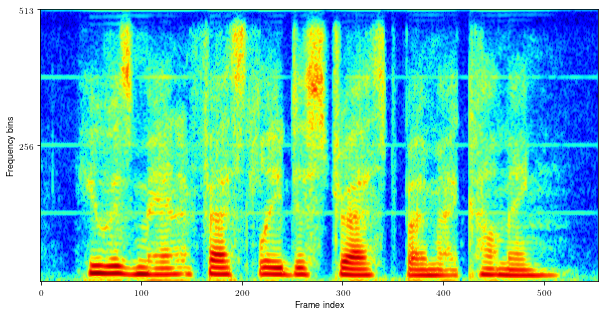

In [35]:
# plot the spectrogram of the generated waveform
plot_API.plot_API(output_waveform[0, :, 0].numpy(), plot_lib.plot_spec, 'single')

You may also try other waveforms in `data_models/acoustic_features/hn_nsf`. 


Note that waveforms I used to train this WaveNet have normalized  amplitude. The normalization tool is the sv56 https://github.com/openitu/STL. If you try part3 of this tutorial and run the script `../project/01-nsf/*/00_demo.sh`, you will download the normalized waveforms of CMU-arctic. There will also be a script to use sv56 `../project/01-nsf/DATA/cmu-arctic-data-set/scripts/wav`. But please compile the sv56 and sox first. 

## Final note

Project to train a new WaveNet using CMU-arctic database is available in `../project/05-nn-vocoders/waveglow`. The pre-trained model was trained on CMU arctic data, which may not be sufficient for WaveGlow. You may try the script on other database. Furthermore, no post-processing is included in this notebook. 

There is another variant `../project/05-nn-vocoders/waveglow-2` that uses a legacy version of WaveNet block for WaveGlow. You may also try that model as well.

That's all